# Circuit Obfuscation using Pauli Gadgets

By Zassenhau's formula, quantum circuits can be expressed as a series of Pauli gadgets.
Pauli gadgets where the Pauli string consists of only $\{I, X\}$ or $\{I, Z\}$ are phase gadgets.

`pauliopt` has a submodule for representing phase gadgets:

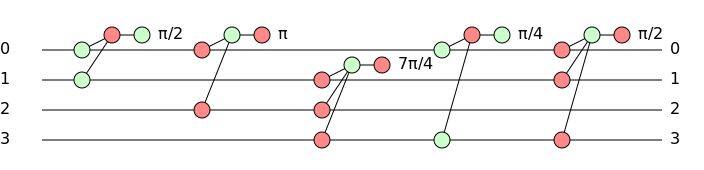

In [1]:
from pauliopt.phase import PhaseCircuit, Z, X, pi

circ = PhaseCircuit(4)
circ >>= Z(pi / 2) @ {0, 1}
circ >>= X(pi) @ {0, 2}
circ >>= X(-pi / 4) @ {1, 2, 3}
circ >>= Z(pi / 4) @ {0, 3}
circ >>= X(pi / 2) @ {0, 1, 3}

circ

`pauliopt` also has a submodule for representing general Pauli gadgets:

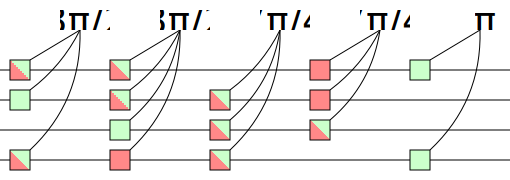

In [2]:
from pauliopt.pauli.pauli_polynomial import PauliPolynomial, PauliGadget, X, Y, Z, I
from random import randint, choice

def gen_random(n_qubits, n_gadgets):
    circ = PauliPolynomial(n_qubits)
    for _ in range(n_gadgets):
        phase = pi / 4 * randint(1, 7)
        pauli_str = [choice([I, X, Y, Z]) for _ in range(n_qubits)]
        while all((p == I for p in pauli_str)):
            pauli_str = [choice([I, X, Y, Z]) for _ in range(n_qubits)]
        circ >>= PauliGadget(phase, pauli_str)
    return circ

circ = gen_random(4, 5)
circ

In [3]:
def gen_p_gadget(gadget):
    """ Return collection of gadgets where the Pauli string is a substring of the original gadget. """
    substrings = set()
    paulis = gadget.paulis
    n_qubits = len(paulis)

    circ = PauliPolynomial(n_qubits)
    for _ in range(2 * n_qubits):
        substring = tuple([I if randint(0, 1) else p for p in paulis])
        if substring not in substrings and not all((p == I for p in substring)):
            phase = pi / 4 * randint(1, 7)
            circ >>= PauliGadget(phase, substring)
            substrings.add(substring)
    return circ

0th Gadget:
slice(0, 1, None)


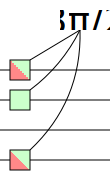

'p gadget' of 0th gadget:


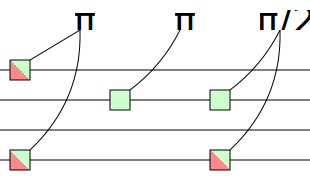

In [4]:
print("0th Gadget:")
display(circ[0:1])
print("'p gadget' of 0th gadget:")
display(gen_p_gadget(circ[0]))

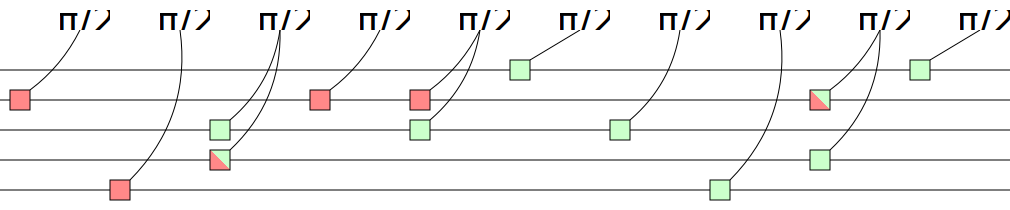

In [5]:
from pauliopt.pauli.clifford_gates import H, S, V, CX, CY, CZ
from pauliopt.pauli.clifford_gates import SingleQubitGate, ControlGate

def cliff_to_pauli(cliff, n_qubits):
    if type(cliff) == CX:
        s = [
            Z if cliff.control == i else
            X if cliff.target == i else I for i in range(n_qubits)
        ]
    elif type(cliff) == CY:
        s = [
            Z if cliff.control == i else
            Y if cliff.target == i else I for i in range(n_qubits)
        ]
    elif type(cliff) == CZ:
        s = [
            Z if cliff.control == i else
            Z if cliff.target == i else I for i in range(n_qubits)
        ]
    elif type(cliff) == H:
        bases = [Z, X, Z]
        for b in bases:
            s = [I] * n_qubits
            s[cliff.qubit] = b
    elif type(cliff) == S:
        s = [I] * n_qubits
        s[cliff.qubit] = Z
    else:
        assert type(cliff) == V
        s = [I] * n_qubits
        s[cliff.qubit] = X
    return PauliGadget(pi / 2, s)


def cliffs_to_pauli(cliffs, n_qubits):
    circ = PauliPolynomial(n_qubits)
    for cliff in cliffs:
        circ >>= cliff_to_pauli(cliff, n_qubits)
    return circ


def random_cliffords(n_qubits, n_gates):
    gates = []
    for i in range(n_gates):
        gate_type = choice([CX, CY, CZ, H, S, V])
        x = choice(range(n_qubits))
        y = x
        while y == x:
            y = choice(range(n_qubits))
        if gate_type in [H, S, V]:
            gate = gate_type(x)
        else:
            assert gate_type in [CX, CY, CZ]
            gate = gate_type(x, y)
        gates.append(gate)
    return gates

cliffs_to_pauli(random_cliffords(5, 10), 5)

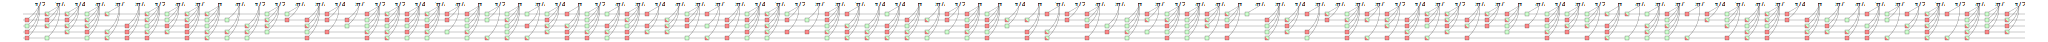

In [6]:
circ = gen_random(5, 100)
n_qubits = 5
circ

In [7]:
def mix_gadgets(circ):
    from random import shuffle
    gadgets = circ.pauli_gadgets.copy()
    shuffle(gadgets)
    return PauliPolynomial(circ.num_qubits, gadgets)

def scramble(circ, i):
    n_qubits = circ.num_qubits
    gs = circ.pauli_gadgets
    left, g, right = circ[:i], circ[i:i+1], circ[i+1:]
    p_gadget = gen_p_gadget(g[0])
    cliffs = cliffs_to_pauli(random_cliffords(n_qubits, 2*n_qubits), n_qubits)

    mid_circ = cliffs >> g >> p_gadget.inverse() >> cliffs.inverse()
    mid_circ = mix_gadgets(mid_circ)
    
    circ = PauliPolynomial(n_qubits)
    circ >>= left
    circ >>= mid_circ
    circ >>= right
    circ >>= p_gadget

    return circ

scramble(circ, 1)

slice(None, 1, None)
slice(1, 2, None)
slice(2, None, None)


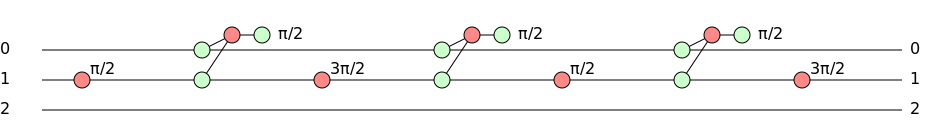

In [8]:
# unrelated: pauliopt has a circuit class now

from pauliopt.circuits import Circuit
from pauliopt.gates import CX, CY, CZ


Circuit(3, [CY(0, 1), CZ(0, 1), CY(0, 1)]).to_phase_circuit()

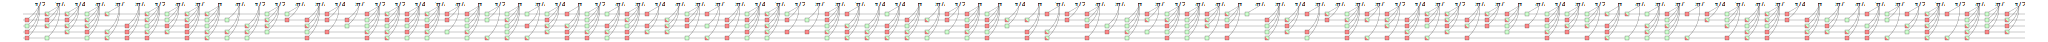

In [9]:
circ

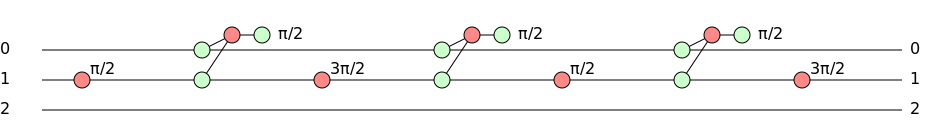

In [10]:
Circuit(3, [CY(0, 1), CZ(0, 1), CY(0, 1)]).to_phase_circuit()